# Regular vs. Robust Standard Errors

## Regular Standard Errors
- Assume constant variance:
  $$
  \text{Var}(\varepsilon_i) = \sigma^2.
  $$
- Variance formula:
  $$
  \text{Var}(\hat{\beta}) = \sigma^2 (X^\top X)^{-1}.
  $$

## Robust Standard Errors
- Allow variance to change with predictors:
  $$
  \text{Var}(\varepsilon_i) \neq \sigma^2.
  $$
- Adjusted variance:
  $$
  \widehat{\text{Var}}(\hat{\beta}) = (X^\top X)^{-1} \left(\sum_{i=1}^n x_i x_i^\top \hat{\varepsilon}_i^2 \right) (X^\top X)^{-1}.
  $$

## Examples
1. **Household Expenditure:** Consumption variance increases with income.
2. **Drug Dosage:** Higher doses cause more varied responses.
3. **Stock Returns:** Volatility increases during high activity.

**Summary:** Use robust standard errors when variance depends on predictors.



Baseline Results:
Coefficient      Manual Beta    Manual Regular SE    Manual Robust SE    Statsmodels Beta    Statsmodels Regular SE    Statsmodels Robust SE
-------------  -------------  -------------------  ------------------  ------------------  ------------------------  -----------------------
Beta_0              6.00092             2.79893             2.73531              6.00092                  2.79893                  2.73531
Beta_1              0.582286            0.0368864           0.0514058            0.582286                 0.0368864                0.0514058


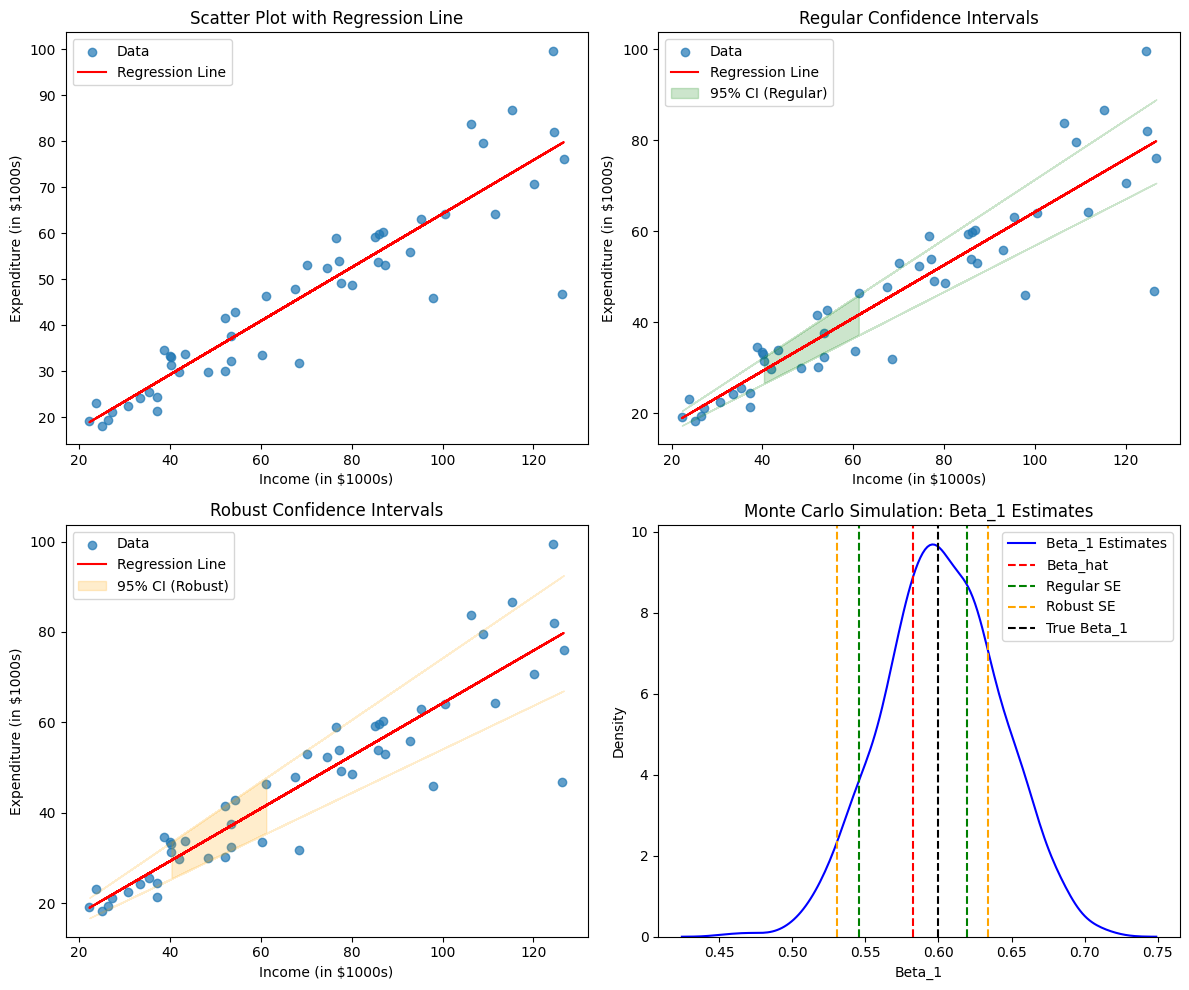

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from tabulate import tabulate

# Set seed for reproducibility
np.random.seed(42)

# Number of observations
n = 50

# Data-generating process (DGP)
def generate_data(n):
    income = np.random.uniform(20, 130, n)  # Income in thousands
    beta_0 = 5  # Intercept
    beta_1 = 0.6  # Marginal propensity to consume
    sigma = 0.3 + 0.1 * income  # Residual standard deviation increases with income
    epsilon = np.random.normal(0, sigma)  # Heteroskedastic noise
    expenditure = beta_0 + beta_1 * income + epsilon
    X = np.column_stack((np.ones(n), income))  # Design matrix with intercept
    return X, expenditure, income

# Monte Carlo Simulation Function
def monte_carlo_simulation(iterations, n):
    beta_1_estimates = []
    for _ in range(iterations):
        X, expenditure, _ = generate_data(n)
        beta_hat = np.linalg.inv(X.T @ X) @ (X.T @ expenditure)
        beta_1_estimates.append(beta_hat[1])
    return np.array(beta_1_estimates)

# Baseline Data
X, expenditure, income = generate_data(n)

# Estimate beta_hat (OLS coefficients)
beta_hat = np.linalg.inv(X.T @ X) @ (X.T @ expenditure)

# Compute residuals
residuals = expenditure - X @ beta_hat

# Regular standard errors
sigma_squared = (residuals**2).sum() / (n - X.shape[1])
cov_beta_regular = sigma_squared * np.linalg.inv(X.T @ X)
std_err_regular = np.sqrt(np.diag(cov_beta_regular))

# Robust (White's) standard errors
meat = X.T @ np.diag(residuals**2) @ X
cov_beta_robust = np.linalg.inv(X.T @ X) @ meat @ np.linalg.inv(X.T @ X)
std_err_robust = np.sqrt(np.diag(cov_beta_robust))

# Check with statsmodels
model = sm.OLS(expenditure, X)
results = model.fit()
results_robust = model.fit(cov_type='HC0')

# Print baseline results in table format
results_table = [
    ["Beta_0", beta_hat[0], std_err_regular[0], std_err_robust[0], results.params[0], results.bse[0], results_robust.bse[0]],
    ["Beta_1", beta_hat[1], std_err_regular[1], std_err_robust[1], results.params[1], results.bse[1], results_robust.bse[1]]
]
print("\nBaseline Results:")
print(tabulate(results_table, headers=["Coefficient", "Manual Beta", "Manual Regular SE", "Manual Robust SE", "Statsmodels Beta", "Statsmodels Regular SE", "Statsmodels Robust SE"]))

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Graph 1: Scatter plot with regression line
axs[0, 0].scatter(income, expenditure, alpha=0.7, label="Data")
axs[0, 0].plot(income, X @ beta_hat, color="red", label="Regression Line")
axs[0, 0].set_title("Scatter Plot with Regression Line")
axs[0, 0].set_xlabel("Income (in $1000s)")
axs[0, 0].set_ylabel("Expenditure (in $1000s)")
axs[0, 0].legend()

# Graph 2: Scatter plot with regular confidence intervals
confidence_interval_regular = 1.96 * std_err_regular[1]
axs[0, 1].scatter(income, expenditure, alpha=0.7, label="Data")
axs[0, 1].plot(income, X @ beta_hat, color="red", label="Regression Line")
axs[0, 1].fill_between(
    income,
    X @ beta_hat - confidence_interval_regular * income,
    X @ beta_hat + confidence_interval_regular * income,
    color="green",
    alpha=0.2,
    label="95% CI (Regular)"
)
axs[0, 1].set_title("Regular Confidence Intervals")
axs[0, 1].set_xlabel("Income (in $1000s)")
axs[0, 1].set_ylabel("Expenditure (in $1000s)")
axs[0, 1].legend()

# Graph 3: Scatter plot with robust confidence intervals
confidence_interval_robust = 1.96 * std_err_robust[1]
axs[1, 0].scatter(income, expenditure, alpha=0.7, label="Data")
axs[1, 0].plot(income, X @ beta_hat, color="red", label="Regression Line")
axs[1, 0].fill_between(
    income,
    X @ beta_hat - confidence_interval_robust * income,
    X @ beta_hat + confidence_interval_robust * income,
    color="orange",
    alpha=0.2,
    label="95% CI (Robust)"
)
axs[1, 0].set_title("Robust Confidence Intervals")
axs[1, 0].set_xlabel("Income (in $1000s)")
axs[1, 0].set_ylabel("Expenditure (in $1000s)")
axs[1, 0].legend()

# Graph 4: Monte Carlo simulation results
iterations = 1000
beta_1_estimates = monte_carlo_simulation(iterations=iterations, n=n)
sns.kdeplot(beta_1_estimates, ax=axs[1, 1], label="Beta_1 Estimates", color="blue")
axs[1, 1].axvline(beta_hat[1], color="red", linestyle="--", label="Beta_hat")
axs[1, 1].axvline(beta_hat[1] - std_err_regular[1], color="green", linestyle="--", label="Regular SE")
axs[1, 1].axvline(beta_hat[1] + std_err_regular[1], color="green", linestyle="--")
axs[1, 1].axvline(beta_hat[1] - std_err_robust[1], color="orange", linestyle="--", label="Robust SE")
axs[1, 1].axvline(beta_hat[1] + std_err_robust[1], color="orange", linestyle="--")
axs[1, 1].axvline(0.6, color="black", linestyle="--", label="True Beta_1")
axs[1, 1].set_title("Monte Carlo Simulation: Beta_1 Estimates")
axs[1, 1].set_xlabel("Beta_1")
axs[1, 1].set_ylabel("Density")
axs[1, 1].legend()

plt.tight_layout()
plt.show()


# Huber-White / Heteroskedasticity-Consistent (HC0, HC1, HC2, HC3)

Heteroskedasticity-Consistent (HC) standard errors are robust estimators designed to handle heteroskedasticity in regression models, where the variance of residuals is not constant. These robust standard errors adjust the variance-covariance matrix to improve inference reliability. Statsmodels supports four primary HC estimators:

## 1. HC0
- Definition: The original heteroskedasticity-consistent standard error proposed by White (1980).
- Adjustment: Uses the squared residuals directly without any additional corrections.
- Best Use Case: Large samples where heteroskedasticity is present.
- Formula:
  $$
  \widehat{\text{Var}}(\hat{\beta}) = (X^\top X)^{-1} \left( \sum_{i=1}^n x_i x_i^\top \hat{\varepsilon}_i^2 \right) (X^\top X)^{-1}
  $$

## 2. HC1
- Definition: A modification of HC0 introduced by MacKinnon and White (1985).
- Adjustment: Incorporates a small-sample correction by scaling the residuals with $ n / (n - k) $, where $ n $ is the number of observations and $ k $ is the number of parameters.
- Best Use Case: Small to moderate samples with heteroskedasticity.
- Formula:
  $$
  \widehat{\text{Var}}(\hat{\beta}) = \frac{n}{n-k} \times \text{HC0}
  $$

## 3. HC2
- Definition: Another variant proposed by MacKinnon and White (1985) to account for influential data points.
- Adjustment: Adjusts residuals by dividing them by $ 1 - h_i $, where $ h_i $ is the leverage of each observation.
- Best Use Case: When influential observations (high leverage) are present.
- Formula:
  $$
  \widehat{\text{Var}}(\hat{\beta}) = (X^\top X)^{-1} \left( \sum_{i=1}^n \frac{x_i x_i^\top \hat{\varepsilon}_i^2}{1 - h_i} \right) (X^\top X)^{-1}
  $$

## 4. HC3
- Definition: A more stringent variant introduced by MacKinnon and White (1985).
- Adjustment: Divides residuals by $ (1 - h_i)^2 $, providing stronger corrections for influential data points.
- Best Use Case: Small samples where influential observations significantly affect variance estimates.
- Formula:
  $$
  \widehat{\text{Var}}(\hat{\beta}) = (X^\top X)^{-1} \left( \sum_{i=1}^n \frac{x_i x_i^\top \hat{\varepsilon}_i^2}{(1 - h_i)^2} \right) (X^\top X)^{-1}
  $$

## Summary Table

| Estimator | Adjustment Factor                     | Best Use Case                       |
|-----------|---------------------------------------|--------------------------------------|
| HC0       | None                                  | Large samples with heteroskedasticity |
| HC1       | $ n / (n - k) $                       | Small to moderate samples           |
| HC2       | $ 1 / (1 - h_i) $                     | Presence of influential points      |
| HC3       | $ 1 / (1 - h_i)^2 $                   | Small samples with high leverage    |

These estimators improve the reliability of inference in the presence of heteroskedasticity, ensuring that standard errors reflect the true variability in the data.


In [106]:
import numpy as np
import statsmodels.api as sm
from tabulate import tabulate

# Data-generating process with normally distributed variables and equal contribution to Y
def generate_data_with_equal_contribution(dgp_type, n=1000):
    np.random.seed()
    if dgp_type == 1:  # Large sample, no outliers
        x = np.random.normal(0, 10, n)
        error = np.random.normal(0, 10, n)
        y = 5 + 2 * x + error
    elif dgp_type == 2:  # Smaller sample, no outliers
        n = 15
        x = np.random.normal(0, 10, n)
        error = np.random.normal(0, 10, n)
        y = 5 + 2 * x + error
    elif dgp_type == 3:  # Large sample, more outliers
        x = np.random.normal(0, 10, n)
        error = np.random.normal(0, 10, n)
        y = 5 + 2 * x + error
        num_outliers = n // 8  # Increase number of outliers
        y[np.random.choice(n, num_outliers)] += np.random.normal(50, 10, num_outliers)
    elif dgp_type == 4:  # Smaller sample, more outliers
        n = 30
        x = np.random.normal(0, 10, n)
        error = np.random.normal(0, 10, n)
        y = 5 + 2 * x + error
        num_outliers = n // 4  # Increase number of outliers
        y[np.random.choice(n, num_outliers)] += np.random.normal(50, 10, num_outliers)
    return x, y

# Calculate robust standard errors
def calculate_hc_se(x, y):
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    cov_types = ['HC0', 'HC1', 'HC2', 'HC3']
    estimates = [model.get_robustcov_results(cov_type=cov).bse[1] for cov in cov_types]
    return estimates

# Monte Carlo simulation for TRUE SE
def monte_carlo_true_se_equal_contribution(dgp_type, iterations=10000):
    beta_1_estimates = []
    for _ in range(iterations):
        x, y = generate_data_with_equal_contribution(dgp_type=dgp_type, n=1000 if dgp_type in [1, 3] else 100)
        X = sm.add_constant(x)
        beta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)
        beta_1_estimates.append(beta_hat[1])
    sampling_std = np.std(beta_1_estimates)
    return sampling_std  # Standard deviation of beta_1 estimates

# Compute estimates and enhanced true SE for each DGP
results_equal_contribution = []
for dgp in range(1, 5):
    print(f"Running Monte Carlo Simulation for DGP {dgp}...")
    x, y = generate_data_with_equal_contribution(dgp_type=dgp, n=1000 if dgp in [1, 3] else 100)
    hc_estimates = calculate_hc_se(x, y)
    true_se_equal = monte_carlo_true_se_equal_contribution(dgp_type=dgp, iterations=5000)
    results_equal_contribution.append(
        [f"DGP {dgp}"] + [round(est, 3) for est in hc_estimates] + [round(true_se_equal, 3)]
    )

# Print the updated results in tabular format
headers_equal_contribution = ["DGP", "HC0 SE", "HC1 SE", "HC2 SE", "HC3 SE", "TRUE SE"]
print("\nFinal Results with Equal Contribution and TRUE SE:")
print(tabulate(results_equal_contribution, headers=headers_equal_contribution, tablefmt="pretty"))



Running Monte Carlo Simulation for DGP 1...
Running Monte Carlo Simulation for DGP 2...
Running Monte Carlo Simulation for DGP 3...
Running Monte Carlo Simulation for DGP 4...

Final Results with Equal Contribution and TRUE SE:
+-------+--------+--------+--------+--------+---------+
|  DGP  | HC0 SE | HC1 SE | HC2 SE | HC3 SE | TRUE SE |
+-------+--------+--------+--------+--------+---------+
| DGP 1 | 0.033  | 0.033  | 0.033  | 0.033  |  0.032  |
| DGP 2 | 0.222  | 0.238  | 0.244  | 0.268  |  0.297  |
| DGP 3 | 0.054  | 0.054  | 0.054  | 0.054  |  0.061  |
| DGP 4 | 0.424  | 0.438  | 0.447  | 0.473  |  0.451  |
+-------+--------+--------+--------+--------+---------+


# HAC (Heteroskedasticity and Autocorrelation Consistent) Standard Errors

HAC standard errors are robust estimators designed to handle violations of classical OLS assumptions, specifically heteroskedasticity (non-constant variance of residuals) and autocorrelation (correlation between residuals over time or other structured sequences). The most commonly used HAC estimator is the **Newey-West** estimator.

## 1. What is Autocorrelation?

Autocorrelation occurs when residuals (\( \varepsilon \)) in a regression model are correlated with each other. This is common in time-series data or panel data with a temporal or spatial structure. For example:
- **Economic Indicators**: Monthly unemployment rates may show persistent trends, leading to correlated errors across months.
- **Weather Data**: Daily temperatures might be similar from one day to the next, causing autocorrelated residuals.
- **Stock Prices**: Returns often exhibit patterns, such as volatility clustering, leading to autocorrelation.

### Effects of Autocorrelation:
- Inflates Type I error rates (rejecting a true null hypothesis).
- Underestimates the true standard error of coefficients, leading to overly narrow confidence intervals.

## 2. HAC Adjustments

HAC standard errors combine corrections for both heteroskedasticity and autocorrelation by modifying the variance-covariance matrix of OLS estimates.

### Formula:
\[
\widehat{\text{Var}}(\hat{\beta}) = (X^\top X)^{-1} \left( \sum_{t=1}^T X_t^\top \varepsilon_t^2 X_t + \sum_{l=1}^L \left( 1 - \frac{l}{L+1} \right) \sum_{t=1}^{T-l} (X_t^\top \varepsilon_t \varepsilon_{t+l} X_{t+l}) \right) (X^\top X)^{-1}
\]

Where:
- \( L \): Number of lags to include.
- \( \varepsilon_t \): Residual at time \( t \).
- \( X_t \): Design matrix for observation \( t \).

---

## 3. Newey-West Estimator

The Newey-West estimator is the most common HAC adjustment. It applies a weighting scheme to autocorrelated residuals, where the weight decreases as the lag increases.

### Features:
- Accounts for heteroskedasticity by using squared residuals (\( \varepsilon_t^2 \)).
- Adjusts for autocorrelation by incorporating residuals from lagged observations (\( \varepsilon_{t+l} \)).
- A tapering function ensures that the influence of lagged residuals decreases as the lag length grows.

---

## 4. When to Use HAC Standard Errors

HAC standard errors are ideal when working with:
1. **Time-Series Data**:
   - E.g., GDP growth, stock returns, monthly sales.
2. **Panel Data**:
   - E.g., tracking multiple individuals over time with structured residual dependencies.

---

## Examples of Autocorrelation

1. **Economic Data**:
   - Quarterly GDP growth often shows autocorrelation due to economic cycles.
2. **Weather Data**:
   - Daily temperature deviations are similar across consecutive days.
3. **Panel Data**:
   - Test scores of students in the same class over multiple years may exhibit correlated errors due to shared teaching styles.

---

## Summary Table

| Feature            | HAC Adjustment                           | Example Use Case                   |
|---------------------|------------------------------------------|------------------------------------|
| Heteroskedasticity  | Weighted by \( \varepsilon_t^2 \)        | Stock returns with varying volatility |
| Autocorrelation     | Includes \( \varepsilon_{t+l} \) terms   | GDP growth, weather data           |
| Tapering Weights    | Reduces lag influence over time          | Time series with short-term trends |

HAC standard errors are essential for robust inference in models where residuals violate independence and homoscedasticity assumptions. They ensure valid hypothesis testing and confidence intervals in complex data environments.

# Clustered Standard Errors

In [70]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from tabulate import tabulate

# Create sample data with clustering
np.random.seed(123)
n_clusters = 100
n_obs_per_cluster = 50
n_total = n_clusters * n_obs_per_cluster

data = pd.DataFrame({
    'cluster': np.repeat(range(n_clusters), n_obs_per_cluster),
    'x': np.random.normal(0, 1, n_total),
    'y': np.random.normal(0, 1, n_total)
})

# Add cluster-specific effect
data['y'] += np.repeat(np.random.normal(0, 0.5, n_clusters), n_obs_per_cluster)

# --------------------------
# Manual Calculations
# --------------------------

# Design matrix and response
X = np.column_stack((np.ones(len(data)), data['x'].values))  # Add constant
y = data['y'].values
clusters = data['cluster'].values

# Calculate OLS estimates (beta_hat)
beta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)

# Residuals
residuals = y - X @ beta_hat

# Regular Variance-Covariance Matrix (Manual)
sigma_squared = (residuals.T @ residuals) / (len(y) - X.shape[1])  # Residual variance
vcov_regular = sigma_squared * np.linalg.inv(X.T @ X)  # Variance-covariance matrix
regular_se_manual = np.sqrt(np.diag(vcov_regular))  # Standard errors

# Bread matrix for cluster SE
bread = np.linalg.inv(X.T @ X)

# Calculate cluster-robust "meat" matrix
unique_clusters = np.unique(clusters)
meat = np.zeros((X.shape[1], X.shape[1]))

for cluster in unique_clusters:
    cluster_mask = clusters == cluster
    X_c = X[cluster_mask, :]
    residuals_c = residuals[cluster_mask]
    meat += X_c.T @ np.outer(residuals_c, residuals_c) @ X_c

# Sandwich estimator for variance-covariance matrix
vcov_cluster = bread @ meat @ bread
cluster_se_manual = np.sqrt(np.diag(vcov_cluster))

# --------------------------
# Comparison with Statsmodels
# --------------------------

# Statsmodels Regular SE
model = sm.OLS(y, X)
results = model.fit()

# Statsmodels Cluster SE
results_cluster = model.fit(cov_type='cluster', cov_kwds={'groups': data['cluster']})

# Prepare comparison table with 4 decimals
comparison_table = [
    ["Intercept", round(beta_hat[0], 4), round(results.bse[0], 4), round(regular_se_manual[0], 4), round(results_cluster.bse[0], 4), round(cluster_se_manual[0], 4)],
    ["Slope", round(beta_hat[1], 4), round(results.bse[1], 4), round(regular_se_manual[1], 4), round(results_cluster.bse[1], 4), round(cluster_se_manual[1], 4)]
]

# Display results
print("\nComparison of Estimates and Standard Errors:")
print(tabulate(comparison_table, headers=["Parameter", "Estimate (Manual)", "Regular SE (Statsmodels)", "Regular SE (Manual)", "Cluster SE (Statsmodels)", "Cluster SE (Manual)"], tablefmt="pretty"))



Comparison of Estimates and Standard Errors:
+-----------+-------------------+--------------------------+---------------------+--------------------------+---------------------+
| Parameter | Estimate (Manual) | Regular SE (Statsmodels) | Regular SE (Manual) | Cluster SE (Statsmodels) | Cluster SE (Manual) |
+-----------+-------------------+--------------------------+---------------------+--------------------------+---------------------+
| Intercept |      0.0513       |          0.016           |        0.016        |          0.0537          |       0.0534        |
|   Slope   |      -0.0028      |          0.0162          |       0.0162        |          0.0172          |       0.0171        |
+-----------+-------------------+--------------------------+---------------------+--------------------------+---------------------+



Comparison of Estimates and Standard Errors:
+-----------+-------------------+---------------------+---------------------+--------------------------+--------------------------+
| Parameter | Estimate (Manual) | Regular SE (Manual) | Cluster SE (Manual) | Regular SE (Statsmodels) | Cluster SE (Statsmodels) |
+-----------+-------------------+---------------------+---------------------+--------------------------+--------------------------+
| Intercept |      5.0354       |       0.4286        |       0.5481        |          0.4286          |          0.5578          |
|   Slope   |      0.5989       |       0.0052        |        0.006        |          0.0052          |          0.0061          |
+-----------+-------------------+---------------------+---------------------+--------------------------+--------------------------+


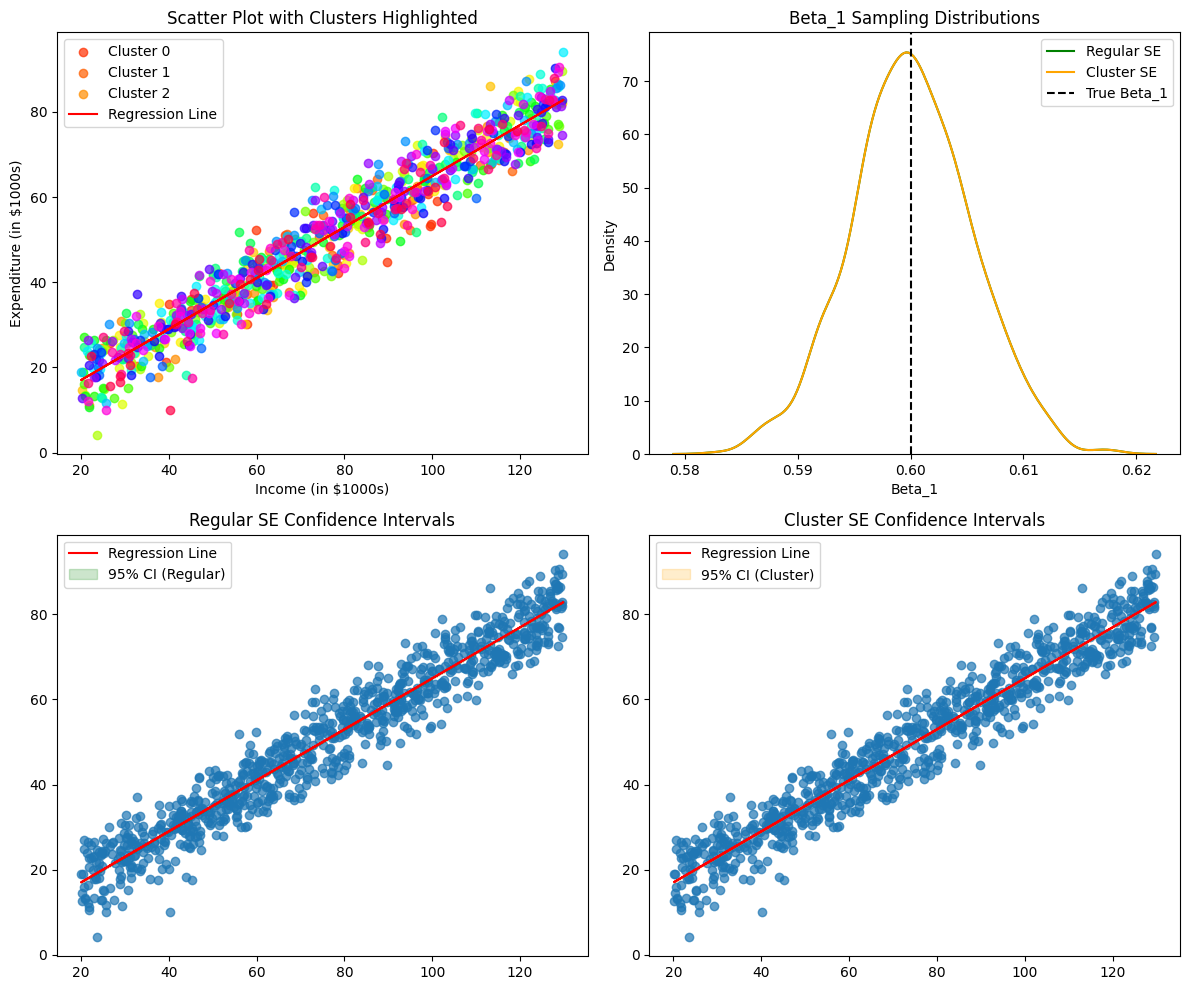


Coverage Results (95% CI):
+------------+----------+
|    Type    | Coverage |
+------------+----------+
| Regular SE |  0.947   |
| Cluster SE |  0.939   |
+------------+----------+


In [91]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

# Create sample data with clustering
np.random.seed(123)
n_clusters = 30
n_obs_per_cluster = 30
n_total = n_clusters * n_obs_per_cluster

# Data-generating process (DGP) with clusters
def generate_cluster_data(n_clusters, n_obs_per_cluster):
    clusters = np.repeat(range(n_clusters), n_obs_per_cluster)
    x = np.random.uniform(20, 130, n_clusters * n_obs_per_cluster)  # Income in thousands
    beta_0 = 5  # Intercept
    beta_1 = 0.6  # Slope
    cluster_effects = np.random.normal(0, 1, n_clusters)  # Cluster-specific effects
    errors = np.random.normal(0, 5, n_clusters * n_obs_per_cluster)  # Residuals
    y = beta_0 + beta_1 * x + cluster_effects[clusters] + errors
    return x, y, clusters

# Generate initial data
x, y, clusters = generate_cluster_data(n_clusters, n_obs_per_cluster)

# Design matrix
X = np.column_stack((np.ones(len(x)), x))

# Calculate OLS estimates (manually)
beta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)

# Residuals
residuals = y - X @ beta_hat

# Regular Variance-Covariance Matrix (manual)
sigma_squared = (residuals.T @ residuals) / (len(y) - X.shape[1])
vcov_regular = sigma_squared * np.linalg.inv(X.T @ X)
std_err_regular = np.sqrt(np.diag(vcov_regular))

# Bread matrix for cluster-robust SE
bread = np.linalg.inv(X.T @ X)

# Cluster-robust "meat" matrix
unique_clusters = np.unique(clusters)
meat = np.zeros((X.shape[1], X.shape[1]))

for cluster in unique_clusters:
    cluster_mask = clusters == cluster
    X_c = X[cluster_mask, :]
    residuals_c = residuals[cluster_mask]
    meat += X_c.T @ np.outer(residuals_c, residuals_c) @ X_c

vcov_cluster = bread @ meat @ bread
std_err_cluster = np.sqrt(np.diag(vcov_cluster))

# Statsmodels verification (optional)
model = sm.OLS(y, X)
results = model.fit()
results_cluster = model.fit(cov_type='cluster', cov_kwds={'groups': clusters})

# Prepare comparison table
comparison_table = [
    ["Intercept", round(beta_hat[0], 4), round(std_err_regular[0], 4), round(std_err_cluster[0], 4), round(results.bse[0], 4), round(results_cluster.bse[0], 4)],
    ["Slope", round(beta_hat[1], 4), round(std_err_regular[1], 4), round(std_err_cluster[1], 4), round(results.bse[1], 4), round(results_cluster.bse[1], 4)]
]

print("\nComparison of Estimates and Standard Errors:")
print(tabulate(comparison_table, headers=["Parameter", "Estimate (Manual)", "Regular SE (Manual)", "Cluster SE (Manual)", "Regular SE (Statsmodels)", "Cluster SE (Statsmodels)"], tablefmt="pretty"))

# Monte Carlo simulation for coverage analysis
def monte_carlo_simulation(iterations, n_clusters, n_obs_per_cluster):
    true_beta_1 = 0.6
    beta_1_estimates_regular = []
    beta_1_estimates_cluster = []
    coverage_regular = 0
    coverage_cluster = 0

    for _ in range(iterations):
        x, y, clusters = generate_cluster_data(n_clusters, n_obs_per_cluster)
        X = np.column_stack((np.ones(len(x)), x))
        beta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)
        residuals = y - X @ beta_hat
        
        # Regular SE
        sigma_squared = (residuals.T @ residuals) / (len(y) - X.shape[1])
        vcov_regular = sigma_squared * np.linalg.inv(X.T @ X)
        std_err_regular = np.sqrt(np.diag(vcov_regular))
        
        # Cluster SE
        meat = np.zeros((X.shape[1], X.shape[1]))
        for cluster in np.unique(clusters):
            cluster_mask = clusters == cluster
            X_c = X[cluster_mask, :]
            residuals_c = residuals[cluster_mask]
            meat += X_c.T @ np.outer(residuals_c, residuals_c) @ X_c
        vcov_cluster = bread @ meat @ bread
        std_err_cluster = np.sqrt(np.diag(vcov_cluster))
        
        # Store estimates
        beta_1_estimates_regular.append(beta_hat[1])
        beta_1_estimates_cluster.append(beta_hat[1])
        
        # Coverage
        if (beta_hat[1] - 1.96 * std_err_regular[1] <= true_beta_1 <= beta_hat[1] + 1.96 * std_err_regular[1]):
            coverage_regular += 1
        if (beta_hat[1] - 1.96 * std_err_cluster[1] <= true_beta_1 <= beta_hat[1] + 1.96 * std_err_cluster[1]):
            coverage_cluster += 1

    coverage_regular /= iterations
    coverage_cluster /= iterations

    return np.array(beta_1_estimates_regular), np.array(beta_1_estimates_cluster), coverage_regular, coverage_cluster

# Run simulation
iterations = 1000
beta_1_regular, beta_1_cluster, coverage_regular, coverage_cluster = monte_carlo_simulation(iterations, n_clusters, n_obs_per_cluster)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Scatter plot with clusters highlighted
colors = sns.color_palette("hsv", n_clusters)
for i, color in enumerate(colors):
    mask = clusters == i
    axs[0, 0].scatter(x[mask], y[mask], color=color, alpha=0.7, label=f"Cluster {i}" if i < 3 else None)
axs[0, 0].plot(x, X @ beta_hat, color="red", label="Regression Line")
axs[0, 0].set_title("Scatter Plot with Clusters Highlighted")
axs[0, 0].set_xlabel("Income (in $1000s)")
axs[0, 0].set_ylabel("Expenditure (in $1000s)")
axs[0, 0].legend()

# Density plot for Beta_1
sns.kdeplot(beta_1_regular, ax=axs[0, 1], label="Regular SE", color="green")
sns.kdeplot(beta_1_cluster, ax=axs[0, 1], label="Cluster SE", color="orange")
axs[0, 1].axvline(0.6, color="black", linestyle="--", label="True Beta_1")
axs[0, 1].set_title("Beta_1 Sampling Distributions")
axs[0, 1].set_xlabel("Beta_1")
axs[0, 1].set_ylabel("Density")
axs[0, 1].legend()

# Scatter plot with regular SE confidence intervals
confidence_interval_regular = 1.96 * std_err_regular[1]
axs[1, 0].scatter(x, y, alpha=0.7)
axs[1, 0].plot(x, X @ beta_hat, color="red", label="Regression Line")
axs[1, 0].fill_between(
    x, X @ beta_hat - confidence_interval_regular, X @ beta_hat + confidence_interval_regular,
    color="green", alpha=0.2, label="95% CI (Regular)"
)
axs[1, 0].set_title("Regular SE Confidence Intervals")
axs[1, 0].legend()

# Scatter plot with cluster SE confidence intervals
confidence_interval_cluster = 1.96 * std_err_cluster[1]
axs[1, 1].scatter(x, y, alpha=0.7)
axs[1, 1].plot(x, X @ beta_hat, color="red", label="Regression Line")
axs[1, 1].fill_between(
    x, X @ beta_hat - confidence_interval_cluster, X @ beta_hat + confidence_interval_cluster,
    color="orange", alpha=0.2, label="95% CI (Cluster)"
)
axs[1, 1].set_title("Cluster SE Confidence Intervals")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

# Coverage Results
print("\nCoverage Results (95% CI):")
coverage_table = [
    ["Regular SE", round(coverage_regular, 4)],
    ["Cluster SE", round(coverage_cluster, 4)],
]
print(tabulate(coverage_table, headers=["Type", "Coverage"], tablefmt="pretty"))


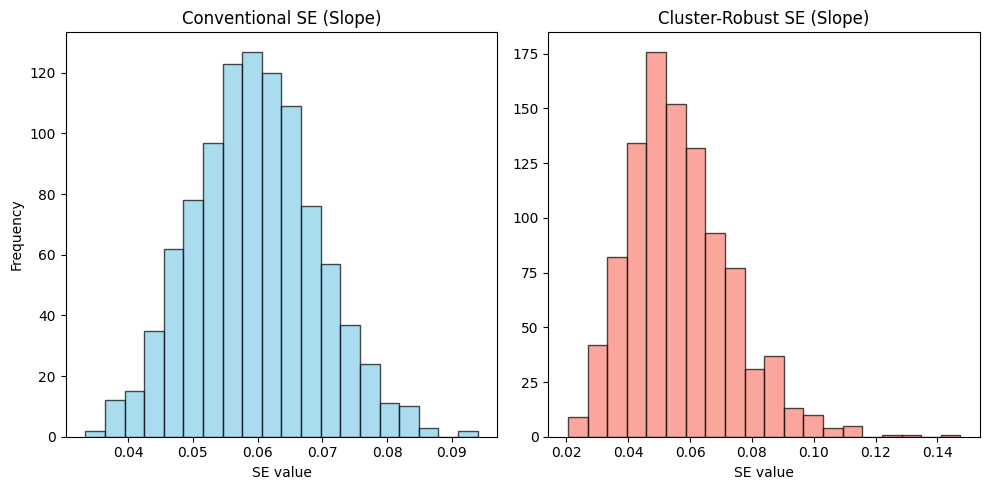

Mean Conventional SE: 0.05962207845256701
Mean Cluster-Robust SE: 0.05691339891992348
Ratio (CR SE / Conv SE): 0.9545691863996583


In [54]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_cluster
import matplotlib.pyplot as plt

np.random.seed(123)

# Simulation Parameters
G = 20        # Number of clusters (e.g., schools)
M = 50        # Observations per cluster (e.g., students per school)
N = G * M
B = 1000      # Number of Monte Carlo replications

# True parameters
beta_0 = 50
beta_1 = 2

# Variances
sigma_U = 5   # Cluster-level random effect std dev
sigma_eps = 1 # Individual-level noise std dev

conv_se_list = []
cluster_se_list = []

for b in range(B):
    # Generate cluster IDs
    clusters = np.repeat(np.arange(G), M)

    # Generate data
    X = np.random.uniform(1, 10, size=N)
    U = np.repeat(np.random.normal(0, sigma_U, G), M)  # cluster effects
    eps = np.random.normal(0, sigma_eps, N)
    Y = beta_0 + beta_1 * X + U + eps

    # Put into dataframe
    data = pd.DataFrame({
        'Y': Y,
        'X': X,
        'cluster': clusters
    })

    # Fit OLS
    X_mat = sm.add_constant(data['X'].values)
    model = sm.OLS(data['Y'].values, X_mat).fit()

    # Conventional SE
    conv_se = np.sqrt(np.diag(model.cov_params()))
    # Cluster-robust SE
    cluster_cov = cov_cluster(model, data['cluster'])
    cluster_se = np.sqrt(np.diag(cluster_cov))

    # Store the slope SEs
    conv_se_list.append(conv_se[1])      # Index 1: slope
    cluster_se_list.append(cluster_se[1])

conv_se_arr = np.array(conv_se_list)
cluster_se_arr = np.array(cluster_se_list)

# Plot histograms of the standard errors
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(conv_se_arr, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Conventional SE (Slope)')
plt.xlabel('SE value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(cluster_se_arr, bins=20, alpha=0.7, color='salmon', edgecolor='black')
plt.title('Cluster-Robust SE (Slope)')
plt.xlabel('SE value')

plt.tight_layout()
plt.show()

# Print some summary statistics
print("Mean Conventional SE:", np.mean(conv_se_arr))
print("Mean Cluster-Robust SE:", np.mean(cluster_se_arr))
print("Ratio (CR SE / Conv SE):", np.mean(cluster_se_arr) / np.mean(conv_se_arr))


In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Create sample data
np.random.seed(123)
n_clusters = 100
n_obs_per_cluster = 50
n_total = n_clusters * n_obs_per_cluster

data = pd.DataFrame({
    'cluster': np.repeat(range(n_clusters), n_obs_per_cluster),
    'x': np.random.normal(0, 1, n_total),
    'y': np.random.normal(0, 1, n_total)
})

# Add cluster-specific effect
data['y'] += np.repeat(np.random.normal(0, 0.5, n_clusters), n_obs_per_cluster)

# Run OLS regression with cluster robust standard errors
X = sm.add_constant(data['x'])
y = data['y']
model = sm.OLS(y, X)
results = model.fit(cov_type='cluster', cov_kwds={'groups': data['cluster']})

print(results.summary())

import statsmodels.api as sm
import pandas as pd
import numpy as np

# Create sample data
np.random.seed(123)
n_total = 5000  # Total number of observations

data = pd.DataFrame({
    'x': np.random.normal(0, 1, n_total),
    'y': np.random.normal(0, 1, n_total)
})

# Add some correlation between x and y
data['y'] += 0.5 * data['x'] + np.random.normal(0, 0.5, n_total)

# Run standard OLS regression
X = sm.add_constant(data['x'])
y = data['y']
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.02673
Date:                Wed, 18 Dec 2024   Prob (F-statistic):              0.870
Time:                        16:34:05   Log-Likelihood:                -7696.3
No. Observations:                5000   AIC:                         1.540e+04
Df Residuals:                    4998   BIC:                         1.541e+04
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0513      0.054      0.955      0.3

In [13]:
import numpy as np
import statsmodels.api as sm

# Simulated data
np.random.seed(42)
n = 100  # Number of observations
k = 3    # Number of predictors (including intercept)

# Generate random data
X = np.random.randn(n, k)
X[:, 0] = 1  # Add intercept
beta_true = np.array([1, 0.5, -0.3])
y = X @ beta_true + np.random.randn(n) * (1 + 0.5 * X[:, 1]**2)  # Heteroskedasticity

# Step 1: OLS estimation (manual)
beta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)

# Step 2: Residuals
residuals = y - X @ beta_hat

# Step 3: Compute robust "meat" matrix
M = X.T @ np.diag(residuals**2) @ X

# Step 4: Robust covariance matrix
cov_beta_robust_manual = np.linalg.inv(X.T @ X) @ M @ np.linalg.inv(X.T @ X)

# Step 5: Robust standard errors
robust_se_manual = np.sqrt(np.diag(cov_beta_robust_manual))

# Using statsmodels for comparison
model = sm.OLS(y, X)
results_ols = model.fit()
results_robust = model.fit(cov_type='HC0')  # White's robust standard errors

# Output results
print("Manual computation of robust standard errors:")
print(robust_se_manual)

print("\nStatsmodels robust standard errors (HC0):")
print(results_robust.bse)

# Comparing OLS and robust results
print("\nOLS standard errors (non-robust):")
print(results_ols.bse)


Manual computation of robust standard errors:
[0.14526905 0.37905587 0.1792505 ]

Statsmodels robust standard errors (HC0):
[0.14526905 0.37905587 0.1792505 ]

OLS standard errors (non-robust):
[0.17496628 0.17770307 0.15633707]


In [11]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from tabulate import tabulate

# Create sample data with clustering
np.random.seed(123)
n_clusters = 100
n_obs_per_cluster = 50
n_total = n_clusters * n_obs_per_cluster

data = pd.DataFrame({
    'cluster': np.repeat(range(n_clusters), n_obs_per_cluster),
    'x': np.random.normal(0, 1, n_total),
    'y': np.random.normal(0, 1, n_total)
})

# Add cluster-specific effect
data['y'] += np.repeat(np.random.normal(0, 0.5, n_clusters), n_obs_per_cluster)

# --------------------------
# Manual Calculations
# --------------------------

# Design matrix and response
X = np.column_stack((np.ones(len(data)), data['x'].values))  # Add constant
y = data['y'].values
clusters = data['cluster'].values

# Calculate OLS estimates (beta_hat)
beta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)

# Residuals
residuals = y - X @ beta_hat

# Regular Variance-Covariance Matrix (Manual)
sigma_squared = (residuals.T @ residuals) / (len(y) - X.shape[1])  # Residual variance
vcov_regular = sigma_squared * np.linalg.inv(X.T @ X)  # Variance-covariance matrix
regular_se_manual = np.sqrt(np.diag(vcov_regular))  # Standard errors

# Bread matrix for cluster SE
bread = np.linalg.inv(X.T @ X)

# Calculate cluster-robust "meat" matrix
unique_clusters = np.unique(clusters)
meat = np.zeros((X.shape[1], X.shape[1]))

for cluster in unique_clusters:
    cluster_mask = clusters == cluster
    X_c = X[cluster_mask, :]
    residuals_c = residuals[cluster_mask]
    meat += X_c.T @ np.outer(residuals_c, residuals_c) @ X_c

# Sandwich estimator for variance-covariance matrix
vcov_cluster = bread @ meat @ bread
cluster_se_manual = np.sqrt(np.diag(vcov_cluster))

# --------------------------
# Comparison with Statsmodels
# --------------------------

# Statsmodels Regular SE
model = sm.OLS(y, X)
results = model.fit()

# Statsmodels Cluster SE
results_cluster = model.fit(cov_type='cluster', cov_kwds={'groups': data['cluster']})

# Prepare comparison table with 4 decimals
comparison_table = [
    ["Intercept", round(beta_hat[0], 4), round(results.bse[0], 4), round(regular_se_manual[0], 4), round(results_cluster.bse[0], 4), round(cluster_se_manual[0], 4)],
    ["Slope", round(beta_hat[1], 4), round(results.bse[1], 4), round(regular_se_manual[1], 4), round(results_cluster.bse[1], 4), round(cluster_se_manual[1], 4)]
]

# Display results
print("\nComparison of Estimates and Standard Errors:")
print(tabulate(comparison_table, headers=["Parameter", "Estimate (Manual)", "Regular SE (Statsmodels)", "Regular SE (Manual)", "Cluster SE (Statsmodels)", "Cluster SE (Manual)"], tablefmt="pretty"))


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.